In [15]:
!pip uninstall -y gymnasium

Found existing installation: gymnasium 1.1.1
Uninstalling gymnasium-1.1.1:
  Successfully uninstalled gymnasium-1.1.1


In [16]:
!pip install gymnasium[atari] ale-py

  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 56.6 MB/s eta 0:00:0000:0100:01
Using cached gymnasium-1.1.1-py3-none-any.whl (965 kB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.1
    Uninstalling ale-py-0.8.1:
      Successfully uninstalled ale-py-0.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires gymnasium==0.29.0, but you have gymnasium 1.1.1 which is incompatible.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.1.1 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [17]:
!pip install gym[atari]

  Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached ale_py-0.8.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.0
    Uninstalling ale-py-0.11.0:
      Successfully uninstalled ale-py-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [18]:
!pip install "gym[atari,accept-rom-license]"

In [19]:
!pip install autorom

In [20]:
!pip install numpy==1.23.5

In [21]:
!AutoROM --accept-license

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/adventure.bin    
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/backgammon.bin
Installed /usr/local/lib/python3.11/dist-packages/AutoROM/roms/bank_heist.bin


In [22]:
import gym
import numpy as np
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class Gray84(gym.ObservationWrapper):
    """RGB → 84×84 gray uint8."""
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(0, 255, (84, 84, 1), np.uint8)

    def observation(self, obs):
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        obs = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)
        return obs[..., None]             # (84,84,1)

class Stack(gym.Wrapper):
    """Channel-last frame stack (k=4)."""
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k
        self.frames = deque(maxlen=k)
        h, w, c = env.observation_space.shape
        self.observation_space = gym.spaces.Box(0, 255, (h, w, c*k), np.uint8)

    def reset(self, **kw):
        obs, _ = self.env.reset(**kw)
        for _ in range(self.k):
            self.frames.append(obs)
        return self._get()

    def step(self, action):
        obs, r, term, trunc, info = self.env.step(action)
        self.frames.append(obs)
        return self._get(), r, term or trunc, info

    def _get(self):
        return np.concatenate(list(self.frames), axis=-1)


In [24]:
class DuelingCNN(nn.Module):
    def __init__(self, n_actions: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Linear(7*7*64, 512)
        self.val = nn.Linear(512, 1)
        self.adv = nn.Linear(512, n_actions)

    def forward(self, x):
        x = x.float() / 255.0
        feats = self.conv(x)
        feats = F.relu(self.fc(feats))
        v   = self.val(feats)                 # (B,1)
        adv = self.adv(feats)                 # (B,|A|)
        q = v + adv - adv.mean(1, keepdim=True)
        return q


In [25]:
class Replay:
    def __init__(self, cap=100_000):
        self.s = np.empty((cap, 84, 84, 4), np.uint8)
        self.a = np.empty(cap, np.uint8)
        self.r = np.empty(cap, np.int8)
        self.d = np.empty(cap, np.bool_)
        self.idx = 0
        self.full = False

    def push(self, state, action, reward, nxt, done):
        self.s[self.idx] = state
        self.a[self.idx] = action
        self.r[self.idx] = np.clip(reward, -1, 1)   # reward clip
        self.d[self.idx] = done
        self.idx = (self.idx + 1) % len(self.a)
        self.full |= self.idx == 0
        self.s[self.idx] = nxt                      # store next state too

    def __len__(self):
        return len(self.a) if self.full else self.idx

    def sample(self, bs):
        idxs = np.random.randint(0, len(self), size=bs)
        s     = torch.as_tensor(self.s[idxs]).permute(0,3,1,2).to(device)
        nxt   = torch.as_tensor(self.s[(idxs+1)%len(self.s)]).permute(0,3,1,2).to(device)
        a     = torch.as_tensor(self.a[idxs], dtype=torch.int64).unsqueeze(1).to(device)
        r     = torch.as_tensor(self.r[idxs], dtype=torch.float32).unsqueeze(1).to(device)
        done  = torch.as_tensor(self.d[idxs], dtype=torch.float32).unsqueeze(1).to(device)
        return s, a, r, nxt, done


In [26]:
class DDQNAgent:
    def __init__(self, n_actions):
        self.policy  = DuelingCNN(n_actions).to(device)
        self.target  = DuelingCNN(n_actions).to(device)
        self.target.load_state_dict(self.policy.state_dict())
        self.opt     = optim.Adam(self.policy.parameters(), lr=2.5e-4, eps=1e-4)
        self.mem     = Replay()
        self.gamma   = 0.99
        self.batch   = 32
        self.learn_every   = 4
        self.train_start   = 20_000
        self.sync_every    = 10_000
        self.step_count    = 0

    def act(self, state, eps):
        if random.random() < eps:
            return random.randrange(self.target.adv.out_features)
        with torch.no_grad():
            s = torch.as_tensor(state).permute(2,0,1).unsqueeze(0).to(device)
            return int(self.policy(s).argmax())

    def learn(self):
        if self.step_count < self.train_start or self.step_count % self.learn_every:
            return
        s, a, r, s2, done = self.mem.sample(self.batch)
        with torch.no_grad():
            best = self.policy(s2).argmax(1, keepdim=True)
            q_next = self.target(s2).gather(1, best)
            y = r + self.gamma * q_next * (1 - done)

        q = self.policy(s).gather(1, a)
        loss = F.smooth_l1_loss(q, y)

        self.opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy.parameters(), 10)
        self.opt.step()

        if self.step_count % self.sync_every == 0:
            self.target.load_state_dict(self.policy.state_dict())


In [27]:
import os, glob, torch

CKPT_DIR   = "checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)
SAVE_EVERY = 250_000        # frames between checkpoints

def save_ckpt(frame, episode, rewards, agent):
    path = f"{CKPT_DIR}/pong_{frame//1000:07d}k.pth"
    torch.save({
        "frame"     : frame,
        "episode"   : episode,
        "rewards"   : rewards,
        "policy"    : agent.policy.state_dict(),
        "target"    : agent.target.state_dict(),
        "optimizer" : agent.opt.state_dict(),
    }, path)
    print(f"✅ checkpoint saved → {path}")

def load_latest_ckpt(agent):
    files = sorted(glob.glob(f"{CKPT_DIR}/pong_*k.pth"))
    if not files:
        print("🔄  no checkpoint found – starting fresh")
        return 0, 0, []
    ckpt = torch.load(files[-1], map_location=device)
    agent.policy.load_state_dict(ckpt["policy"])
    agent.target.load_state_dict(ckpt["target"])
    agent.opt.load_state_dict(ckpt["optimizer"])
    print(f"🔄  resumed from {files[-1]}")
    return ckpt["frame"], ckpt["episode"], ckpt["rewards"]

In [28]:
# Initialize environment and agent
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = Stack(Gray84(env), 4)
agent = DDQNAgent(env.action_space.n)

# Load the uploaded checkpoint
uploaded_path = "/kaggle/input/pong_0001000k/pytorch/default/1/pong_0001000k.pth"
ckpt = torch.load(uploaded_path, map_location=device)
agent.policy.load_state_dict(ckpt["policy"])
agent.target.load_state_dict(ckpt["target"])
agent.opt.load_state_dict(ckpt["optimizer"])
start_frame = ckpt["frame"]
start_ep = ckpt["episode"]
rewards = ckpt["rewards"]
agent.step_count = start_frame
print(f"✅ Resumed from frame {start_frame}, episode {start_ep}")

# Start environment after resume
state = env.reset()
episode = start_ep
episode_reward = 0

# Training loop
for frame in range(start_frame + 1, 3_000_001):
    eps = max(0.05, 1.0 - frame / 1_000_000)
    action = agent.act(state, eps)

    next_state, r, done, _ = env.step(action)
    agent.mem.push(state, action, r, next_state, done)
    agent.learn()

    state = next_state
    episode_reward += r
    agent.step_count += 1

    if done:
        episode += 1
        rewards.append(episode_reward)
        state = env.reset()
        episode_reward = 0

    if frame % 10_000 == 0:
        avg = np.mean(rewards[-20:]) if rewards else 0
        print(f"[{frame:,}] ep {episode} | avg(20) {avg:+.2f} | ε {eps:.3f}")

    if frame % SAVE_EVERY == 0:
        save_ckpt(frame, episode, rewards, agent)

✅ Resumed from frame 1000000, episode 723
[1,010,000] ep 725 | avg(20) -13.15 | ε 0.050
[1,020,000] ep 728 | avg(20) -12.65 | ε 0.050
[1,030,000] ep 731 | avg(20) -12.00 | ε 0.050
[1,040,000] ep 734 | avg(20) -12.45 | ε 0.050
[1,050,000] ep 737 | avg(20) -12.45 | ε 0.050
[1,060,000] ep 740 | avg(20) -12.30 | ε 0.050
[1,070,000] ep 744 | avg(20) -12.35 | ε 0.050
[1,080,000] ep 747 | avg(20) -13.45 | ε 0.050
[1,090,000] ep 751 | avg(20) -14.10 | ε 0.050
[1,100,000] ep 754 | avg(20) -13.85 | ε 0.050
[1,110,000] ep 756 | avg(20) -13.80 | ε 0.050
[1,120,000] ep 760 | avg(20) -14.60 | ε 0.050
[1,130,000] ep 763 | avg(20) -14.80 | ε 0.050
[1,140,000] ep 765 | avg(20) -14.35 | ε 0.050
[1,150,000] ep 768 | avg(20) -13.85 | ε 0.050
[1,160,000] ep 771 | avg(20) -13.80 | ε 0.050
[1,170,000] ep 774 | avg(20) -13.20 | ε 0.050
[1,180,000] ep 777 | avg(20) -12.45 | ε 0.050
[1,190,000] ep 780 | avg(20) -11.50 | ε 0.050
[1,200,000] ep 782 | avg(20) -11.05 | ε 0.050
[1,210,000] ep 785 | avg(20) -10.45 | 

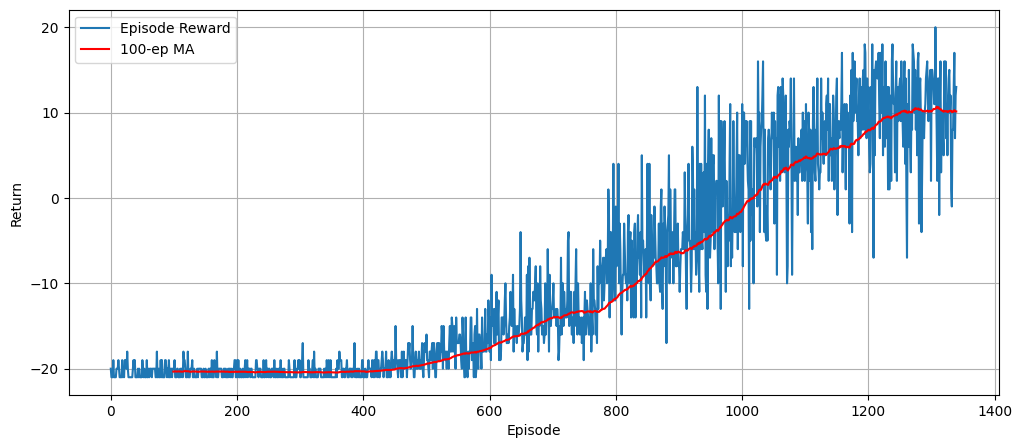

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Saved pong_final.mp4


In [29]:
plt.figure(figsize=(12,5))
plt.plot(rewards, label="Episode Reward")
if len(rewards) > 100:
    mv = np.convolve(rewards, np.ones(100)/100, mode="valid")
    plt.plot(range(99, len(rewards)), mv, label="100-ep MA", color="red")
plt.legend(); plt.grid(); plt.xlabel("Episode"); plt.ylabel("Return"); plt.show()

# record one greedy episode
import imageio, cv2
frames = []
s = env.reset()
done=False
while not done:
    frames.append(env.render())
    a = agent.act(s, 0.0)
    s, _, done, _ = env.step(a)

h,w,_ = frames[0].shape
vid = cv2.VideoWriter("pong_final.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (w,h))
for f in frames: vid.write(cv2.cvtColor(f,cv2.COLOR_RGB2BGR))
vid.release()
print("Saved pong_final.mp4")
